In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import seaborn as sns

A multivariate normal distribution is defined by its pdf: 
$$f(x) = \frac{1}{\sqrt{2\pi^d|\Sigma|}}e^{\frac{-1}{2}(x - \mu)^T\Sigma^{-1}(x - \mu)}$$
where $d$ is the number of dimensions of the distribution (the number of means), $\mu$ is the vector of means, and $\Sigma$ is the covariance matrix (and $|\Sigma| = det(\Sigma)$ ).

<hr>

From here we know a bivariate normal distribution is just a special case of the mutlivariate where $d = 2$. So the pdf of a bivariate normal distribution is: 
$$f(x) = \frac{1}{2\pi \sqrt{|\Sigma|}}e^{\frac{-1}{2}(x - \mu)^T\Sigma^{-1}(x - \mu)}$$

<hr>

We'll draw 100 points from the bivariate distribution and get the correlation between the two variables

In [39]:
mus = [1, -1]
cov = [[0.8, 0.5], [0.5, 0.4]]

X = np.random.multivariate_normal(mus, cov, size=100)
X[:5]

array([[ 0.25454759, -1.18335531],
       [ 2.58216497, -0.43889706],
       [-1.24475979, -2.70574046],
       [ 1.38039337, -0.57894684],
       [ 0.45360145, -0.87142858]])

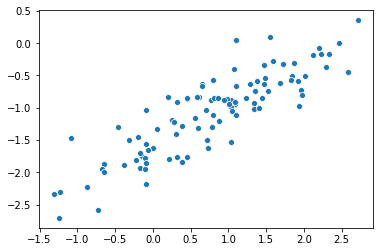

In [40]:
sns.scatterplot(X[:,0], X[:,1])

In [41]:
corr, p_val = stats.pearsonr(X[:,0], X[:,1])
corr

0.866217148221538

We'll repeat this process 1000 times of drawing 100 points and getting the pearson correlation. We will then draw a histogram of the correlations.

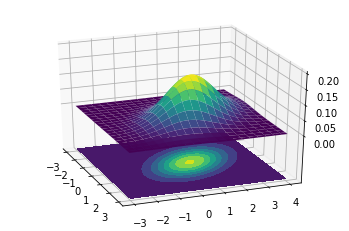

In [44]:
# Code for plotting bivariate normal found @ https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/
def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 4, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 1.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)

plt.show()